# <center>STA 141B Final Project: College Scorecard Data Analysis</center>
#### <center>Abhay Thacker, Alison Wong, Josh Hernandez</center>

# Introduction

As the Biden Administration announced their student loan forgiveness plan in August of 2022, it came to our minds that attending college comes with many financial burdens. With having a bachelor's degree being more common than ever and many jobs requiring at least a bachelor’s degree, we are interested in analyzing the overall value of an undergraduate degree and whether attending college is a worthwhile investment in the long run for all students, especially ones that require students to take out loans to pay for their college tuition. 

We think exploring the growth and decline of debt and the value of college provides insight into our usefulness and our meaning as college students. College has always been seen as the “right” thing to go to, especially in most cultures, but is the value really there to back up this claim? Our research hopes to answer that question and provides meaning to us, since we are, after all, undergraduate college students who hope to profit from our decision to receive undergraduate education. 

__With this in mind, we came up with the following questions:__
* How have student debt and post-graduate income changed over the past 10 years?
* Is there any correlation between median projected income, completion rate, and cost of tuition?
* Is there a significant difference in median earnings (10 years after graduation) and student debt in public vs. private institutions?


# Dataset Summary

To investiage the questions we posed, we used data from **College Scorecard**, an online database maintained by the **United States Department of Education**. It contains over 3,000 distinct features spanning the past 50+ years regarding various aspects of colleges and universities in the U.S. including the cost of attendence, student debt-levels, and post-college earnings. The database is intended to help parents and students compare the cost and value of educational institutions, so it contains sufficient data for us to perform a comprehensive analysis of the value of college.  

## Features
The data set's features are broadly divided into the following 10 categories:

`Root`: University ID information

`Academics`: University academic programs and degrees offered

`Admissions`: Test scores and admissions rates

`Aid`: Amount and type of aid received by students

`Completion`: Number and types of students that completed degrees

`Cost`: Cost of attendance based on various factors

`Earnings`: Student financial information post-graduation

`Repayment`: Numbers regarding student debt repayment

`School`: General information about the institution

`Student`: Demographic, social, and financial information regarding the student body

## Data Collection and Access

The dataset is available as a downloadable file, but as the raw data files are extremely large, we used the web API maintained by the U.S. Department of Education to query the dataset. We developed a few helper functions to simplify the process of querying from the web API. 

### Environment Setup

The following are all of the packages and dependencies used throughout our analysis.

In [1]:
# Import necessary libraries
import requests
import requests_cache
import time
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import scipy
import seaborn as sns
import numpy as np

# Import API Keys
from keys import college_scorecard_key

# Set up request caching
requests_cache.install_cache('141b_project_cache')

# Matplotlib jupyter integration
%matplotlib inline

# Suppress Pandas SettingWithCopyWarning Output
pd.options.mode.chained_assignment = None

### Data Collection Functions

We started by developing a simple function, `get_score_card_data` to query one feature from the database from a given year. This function abstracts away the complexity of making a request to the database (i.e. the need for an access key, the endpoint, the request format, etc.), making it easy to query the database throughout the project.

In [2]:
def get_scorecard_data(year, dev_category, var_name, page=0, per_page=100):
    """
    Retrieves one feature for a specified year from College Scorecard database
    
    Parameters
    ----------
    year : string
        The year you want to query from
    dev_category: string
        Top-level database category the feature is contained in
    var_name: string
        The feature you want to query
    page: int
        The page you want to query
        Defaults to 0
    per_page: int
        How many entries to include in each request
        Defaults to 100
    
    Returns
    -------
    res : Python Requests.response Object
        A response object containing the API's resposne (data, response status, etc.)
    """
    endpoint = "https://api.data.gov/ed/collegescorecard/v1/schools"
    params = {
        "api_key": college_scorecard_key,
        "page": page,
        "per_page": per_page,
        "fields": "id,school.name,school.state,school.ownership,{0}.{1}.{2}".format(year, dev_category, var_name),
        "school.operating": "1", # Currently certified as operating
        "school.degrees_awarded.predominant": "3" # Predominantly bachelor's-degree granting
    }
    
    res = requests.get(endpoint, params)
    
    if(res.status_code != 200):
        print("Error:", res)
        return -1
    else:
        return res

Since our project involves analyzing trends for different financial variables across years, we also developed a function, `get_all_data_for_year` to retrieve all data for a given feature for the entire year. This greatly simplifies the process of comparing trends in data points over time.

In [3]:
def get_all_data_for_year(year, dev_category, var_name):
    """
    Retrieves all data for one feature for the specified year (i.e. all debt data for 2020)
    
    Parameters
    ----------
    year : string
        The year you want to query from
    dev_category: string
        Top-level database category the feature is contained in
    var_name: string
        The feature you want to query
    
    Returns
    -------
    results: Pandas Data frame
        A dataframe containing the entire year's data for the given feature
    """
    data = get_scorecard_data(year = year, dev_category = dev_category, var_name = var_name)
    
    if(not data):
        print("Error: Failed to get score card data.")
    
    data = data.json()
    num_pages = data["metadata"]["total"] // 100 + 1
    curr_page = data["metadata"]["page"] + 1
    
    results = data["results"]
    for page in range(curr_page, num_pages+1):
        results += get_scorecard_data(year = year, dev_category = dev_category, var_name = var_name, page = page).json()["results"]
        time.sleep(0.1)
    
    return pd.DataFrame(results)

Having set up all of these data collection helper functions, we can move on to addressing the research questions posed.

## Research Limitiations/Decisions

For this report, we have decided to analyze data between the years 2011 and 2018 due to scarce data availability for years outside of this range. Furthermore, the College Scorecard dataset also includes data on U.S. territories, but we have limited the scope of our analysis to only include the U.S. commonwealth (50 states).

# Student Loan Debt vs College Graduate Income

In the past few years, there has been growing concern over whether attending college is a worthwhile investment. As the cost of attending college has increased substantially over the past few decades, student debt has become a nationwide concern.


To explore whether or not attending college is a financially sound decision, we analyzed the cost of college and contrasted it to post-graduation salary perspectives for undergraduate students. More specifically, we wanted to **analyze how college debt and income have changed over the past decade** to see if the financial burdens associated with college are compensated by higher salaries.

## Student Loan Debt Analysis

We start by analyzing student loan debt data from College Scorecard between the years 2011-2018 to see how it has evolved over the past few years.

To do this, we simply use the `get_all_data_for_year` function developed to loop through the years we are interested in and concatenate all of the data into a single Pandas data frame.

In [4]:
# Set the year range we are interested in
START_YEAR = 2011
END_YEAR = 2018

# Generate a list of all years in the given range (years are converted to strings)
years = range(START_YEAR, END_YEAR + 1)
years = [str(year) for year in years]

full_debt_data = pd.DataFrame()

for year in years:
    # Retrieve all debt data for the specified year from scorecard
    year_debt_data = get_all_data_for_year(year = year, dev_category = "aid", var_name = "loan_principal")
    
    # Format the resulting data frame
    year_debt_data = year_debt_data.rename(columns = { "{0}.aid.loan_principal".format(year): "debt", "school.name": "name", "school.state": "state", "school.ownership": "ownership" })
    year_debt_data["year"] = year
    
    # Append current year's debt data to larger data frame
    full_debt_data = pd.concat([full_debt_data, year_debt_data], axis=0)

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
full_debt_data = full_debt_data[~full_debt_data["state"].isin(US_TERRITORIES)]
    
# Set the college id as row indicies
full_debt_data = full_debt_data.set_index("id") 

In [5]:
full_debt_data.head(10)

,debt,name,state,ownership,year
id,,,,,
100654,11600.0,Alabama A & M University,AL,1,2011
100663,10276.0,University of Alabama at Birmingham,AL,1,2011
100706,11250.0,University of Alabama in Huntsville,AL,1,2011
100724,9500.0,Alabama State University,AL,1,2011
100751,12527.0,The University of Alabama,AL,1,2011
100812,11192.0,Athens State University,AL,1,2011
100830,6762.0,Auburn University at Montgomery,AL,1,2011
100858,14750.0,Auburn University,AL,1,2011
100937,17500.0,Birmingham-Southern College,AL,2,2011


If we look at the above, we can see that the dataset now contains a list of universities, the state they are in, and the average student loan debt the student body had in a given year. To more clearly see how this has evolved over the past few years, we made a choropleth map to display the average debt per state over the years 2011-2018.

In [ ]:
# Compute average debt for each state for each year in the provided range
mean_debt = full_debt_data.groupby(["state", "year"], as_index=False)["debt"].mean()

# Visualize debt in choropleth with a slider to view different years
fig = px.choropleth(
    mean_debt,
    locations='state', 
    locationmode="USA-states", 
    scope="usa",
    color='debt',
    color_continuous_scale="Reds", 
    animation_frame="year",
    range_color=(min(mean_debt["debt"]), max(mean_debt["debt"])) # Fix color scale
);

fig.update_layout(
    title_text = 'Average Student Loan Debt by State (2011 - 2018)',
    title_font_size = 20,
    title_x=0.45, 
);

fig.show()

From the above animation, it is clear that nationwide student loan debt has increased substantially over the past decade as all states appear a darker shade of red on the choropleth map over time. Some notable features that that the choropleth highlights:
* Universities on the west and east coast have the highest student debt and this feature persists across all years
* Debt levels rose at a slower rate nationwide between the years 2016-2018 relative to earlier years

While it is easy to analyze nationwide trends on the choropleth, it is difficult to analyze trends for specific states and between specific states. To better analyze each state's student loan debt trend, we made a barplot plotting each state's change in student debt from 2011 to 2018.

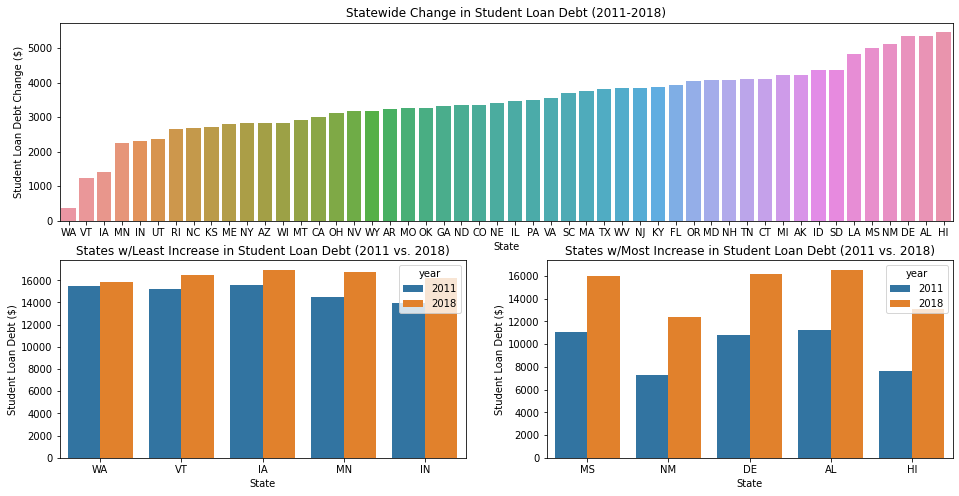

In [7]:
# Subset mean debt to only include rows from 2011 and 2018
state_debt_trends = mean_debt[np.logical_or(mean_debt["year"] == "2011", mean_debt["year"] == "2018")]
state_debt_trends["Debt Change"] = state_debt_trends.groupby(["state"])["debt"].diff()

plt.figure(figsize=(16, 8))

# Plot all state trends
plt.subplot(211)
state_order = state_debt_trends.dropna().sort_values("Debt Change").state

all_states_plot = sns.barplot(data=state_debt_trends.dropna(), x="state", y="Debt Change", order=state_order)
all_states_plot.set(xlabel="State", ylabel="Student Loan Debt Change ($)", title="Statewide Change in Student Loan Debt (2011-2018)")

# Plot bottom 5 states
plt.subplot(223)
bottom_five_states = state_debt_trends.dropna().sort_values(by=['Debt Change']).head(5)["state"]
bottom_five_states_data = state_debt_trends[state_debt_trends["state"].isin(bottom_five_states)]
state_order = bottom_five_states_data.dropna().sort_values("Debt Change").state

bot_states_plot = sns.barplot(data=bottom_five_states_data, x="state", y="debt", hue="year", order=state_order)
bot_states_plot.set(xlabel="State", ylabel="Student Loan Debt ($)", title="States w/Least Increase in Student Loan Debt (2011 vs. 2018)")

# Plot top 5 states
plt.subplot(224)
top_five_states = state_debt_trends.dropna().sort_values(by=['Debt Change']).tail(5)["state"]
top_five_states_data = state_debt_trends[state_debt_trends["state"].isin(top_five_states)]
state_order = top_five_states_data.dropna().sort_values("Debt Change").state

top_states_plot = sns.barplot(data=top_five_states_data, x="state", y="debt", hue="year", order=state_order)
top_states_plot.set(xlabel="State", ylabel="Student Loan Debt ($)", title="States w/Most Increase in Student Loan Debt (2011 vs. 2018)");


**All State Change in Student Loan Debt (Upper Plot)**:  
In the upper plot, we graphed each state's change in student loan debt from 2011 to 2018. We can see that across all states, student loan debt has increased on average between \\$400 - \\$5,000 depending on the state. However, the distribution is clearly left-skewed with most states observing an increase of around \\$3,000.

To further analyze the changes in debt, we created bar plots comparing average student loan debt from 2011 to 2018 for the states with the lowest increase in debt (left plot) and the states with the highest increase in debt (right plot).

**States with Lowest Increase in Debt (Bottom Left Plot)**:  
The state with the lowest increase, and a clear outlier in the dataset, was Washington with an average increase in student loan debt of \\$400. However, when looking at the bottom left plot, we can see that Washington already had a fairly high average student loan debt of \\$14,200 in 2011. A similar trend can be seen among all states in the bottom five, as all of them had fairly high average student debt in 2011. This likely explains the relatively minimal increases.

**States with Highest Increase in Debt (Bottom Right Plot)**:  
The opposite can be said about the states with the largest increases, Hawaii and Alabama with an average increase of approximately \\$5,000. However, in 2011, they were among the states with the lowest average student loan debt at \\$7,600 and \\$7,800 respectively.

**Overall**:  
From this analysis, we can see that the states that experience the highest increase in student loan debt had relatively low average student loan debt in 2011, and the states that experience the lowest increase had relatively high student loan debt in 2011. This potentially indicates that nationwide student loan debt is plateauing at the upper end of \\$16,000.

To look into this hypothesis and further our analysis, we looked at the nationwide trend in student loan debt.

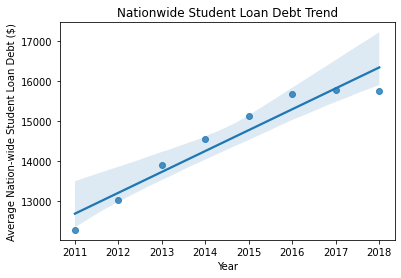

In [8]:
# Group the debt data by year
mean_yearly_debt = mean_debt.groupby(["year"], as_index=False).mean()

# Convert year into a float from string so we can fit a regression line
mean_yearly_debt["year"] = mean_yearly_debt["year"].astype("float64")

# Plot yearly debt and fit a regression line to visualize trend
lin_plot = sns.regplot(data = mean_yearly_debt, x = "year", y = "debt")
lin_plot.set(xlabel='Year', ylabel="Average Nation-wide Student Loan Debt ($)", title="Nationwide Student Loan Debt Trend");

From the plot, we can see that, on average, student-loan debt has increased from \\$12,500 to \\$16,000 from 2011 to 2018. If we examine the individual data points more carefully, we can notice a slight dip from the original linear increase that is observed between 2011 to 2016 in the last few years. This indicates that debt levels nationwide may be plateauing.

## College Graduate Income Analysis

Now we move on to looking at college graduate salaries. We perform a similar analysis by first collecting all the needed data from College Scorecard and making a choropleth chart to visualize the data.

The one noteworthy aspect of data collection in this section is we had to limit our list of years to ["2011", "2012", "2013", "2014", "2018"]. This is because College Scorecard did not have data for the years in between these.

In [9]:
# Set the year range we are interested in
START_YEAR = 2011
END_YEAR = 2018

# Manually set years: only 2011, 2012, 2013, 2014, 2018 available
years = ["2011", "2012", "2013", "2014", "2018"]

full_income_data = pd.DataFrame()

for year in years:
    # Retrieve all income data for the specified year from scorecard
    year_income_data = get_all_data_for_year(year = year, dev_category = "earnings", var_name = "10_yrs_after_entry.median")
    
    # Format the resulting data frame
    year_income_data = year_income_data.rename(columns = { "{0}.earnings.10_yrs_after_entry.median".format(year): "income", "school.name": "name", "school.state": "state", "school.ownership": "ownership" })
    year_income_data["year"] = year
    
    # Remove any NA entries
    year_income_data = year_income_data.dropna(subset=["income"])
    
    # Append current year's income data to larger data frame
    full_income_data = pd.concat([full_income_data, year_income_data], axis=0)

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
full_income_data = full_income_data[~full_income_data["state"].isin(US_TERRITORIES)]

# Set the college id as row indicies
full_income_data = full_income_data.set_index("id") 

In [10]:
full_income_data.head(10)

,income,name,state,ownership,year
id,,,,,
100654,31400.0,Alabama A & M University,AL,1,2011
100663,40300.0,University of Alabama at Birmingham,AL,1,2011
100706,46600.0,University of Alabama in Huntsville,AL,1,2011
100724,27800.0,Alabama State University,AL,1,2011
100751,42400.0,The University of Alabama,AL,1,2011
100812,39700.0,Athens State University,AL,1,2011
100830,34800.0,Auburn University at Montgomery,AL,1,2011
100858,45400.0,Auburn University,AL,1,2011
100937,41900.0,Birmingham-Southern College,AL,2,2011


If we look at the above, we can see that the dataset now contains a list of universities, the state they are in, and the average student post-graduation income in a given year. To see how post-graduation income has evolved over time, we made a choropleth map to display the average post-graduation income per state over the years 2011-2018.

In [11]:
# Compute average income for each state for each year in the provided range
mean_income = full_income_data.groupby(["state", "year"], as_index=False)["income"].mean()

# Visualize income in choropleth with a slider to view different years
fig = px.choropleth(
    mean_income,
    locations='state', 
    locationmode="USA-states", 
    scope="usa",
    color='income',
    color_continuous_scale="Greens", 
    animation_frame="year",
    range_color=(min(mean_income["income"]), max(mean_income["income"])) # Fix color scale
);

fig.update_layout(
    title_text = 'Average Student Income 10 Years After Graduation by State (2011 - 2018)',
    title_font_family="Times New Roman",
    title_font_size = 20,
    title_font_color="black", 
    title_x=0.45, 
);

fig.show()

From the above animation, it is clear that nationwide student post-graduation income has also increased considerably over the past decade as all states appear a darker shade of green over time. Some notable features that that the choropleth highlights:
* Universities on the west and east coast have the highest post-graduation income and this feature persists across all years
* Income levels rose at a slower rate nationwide between the years 2011-2013 relative to later years  

However, it is worth mentioning that the increase in post-graduation income between 2014 and 2018 is hard to analyze due to the lack of data for the years in between.

We continue our analysis by making a barplot plotting each state's change in student debt from 2011 to 2018.

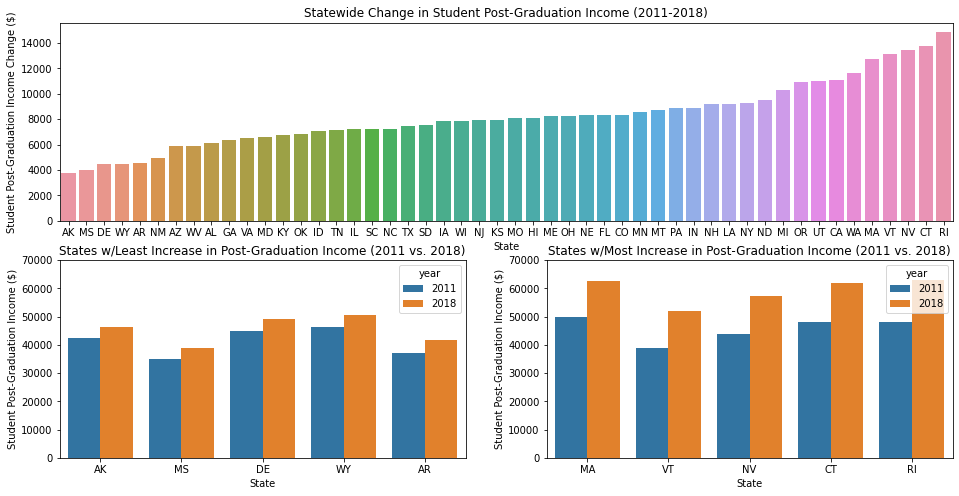

In [12]:
# Subset mean income to only include rows from 2011 and 2018
state_income_trends = mean_income[np.logical_or(mean_income["year"] == "2011", mean_income["year"] == "2018")]
state_income_trends["Income Change"] = state_income_trends.groupby(["state"])["income"].diff()

plt.figure(figsize=(16, 8))

# Plot all state trends
plt.subplot(211)
state_order = state_income_trends.dropna().sort_values("Income Change").state

all_states_plot = sns.barplot(data=state_income_trends.dropna(), x="state", y="Income Change", order=state_order)
all_states_plot.set(xlabel="State", ylabel="Student Post-Graduation Income Change ($)", title="Statewide Change in Student Post-Graduation Income (2011-2018)")

# Plot bottom 5 states
plt.subplot(223)
bottom_five_states = state_income_trends.dropna().sort_values(by=['Income Change']).head(5)["state"]
bottom_five_states_data = state_income_trends[state_income_trends["state"].isin(bottom_five_states)]
state_order = bottom_five_states_data.dropna().sort_values("Income Change").state

plt.ylim(0, 70000)
bot_states_plot = sns.barplot(data=bottom_five_states_data, x="state", y="income", hue="year", order=state_order)
bot_states_plot.set(xlabel="State", ylabel="Student Post-Graduation Income ($)", title="States w/Least Increase in Post-Graduation Income (2011 vs. 2018)")

# Plot top 5 states
plt.subplot(224)
top_five_states = state_income_trends.dropna().sort_values(by=['Income Change']).tail(5)["state"]
top_five_states_data = state_income_trends[state_income_trends["state"].isin(top_five_states)]
state_order = top_five_states_data.dropna().sort_values("Income Change").state

plt.ylim(0, 70000)
top_states_plot = sns.barplot(data=top_five_states_data, x="state", y="income", hue="year", order=state_order)
top_states_plot.set(xlabel="State", ylabel="Student Post-Graduation Income ($)", title="States w/Most Increase in Post-Graduation Income (2011 vs. 2018)");


**All States Change in Post Graduation Income (Upper Plot)**:  
In the upper plot, we graphed each state's change in post-graduation income from 2011 to 2018. We can see that across all states, post-graduation income has increased on average between \\$4,000 to \\$15,000 depending on the state. Similar to the student debt distribution, the post-graduation income distribution is also left-skewed with most states observing an increase of around \\$8,000.  

**States with Lowest Increase in Post-Graduation Income**:  
The state with the lowest increase in income was Alaska with an average increase in post-graduation income of \\$4,000.  

**States with Highest Increase in Post-Graduation Income**:  
The states with the highest increases were Rhode Island and Connecticut with increases ranging from \\$12,000 to \\$14,000. A noteworthy feature about the states with the highest increase is that 4/5 of the states are on the east coast, which traditionally is known to have higher salaries than the rest of the country.

Finally, we analyzed nationwide average post-graduation income to see if there were any significant trends.

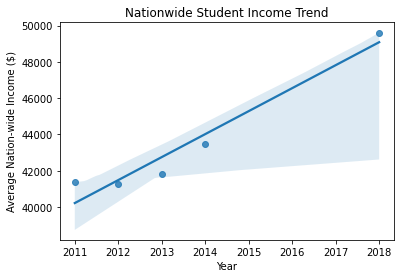

In [13]:
mean_yearly_income = mean_income.groupby(["year"], as_index=False).mean()
mean_yearly_income["year"] = mean_yearly_income["year"].astype("float64")

lin_plot = sns.regplot(data = mean_yearly_income, x = "year", y = "income")
lin_plot.set(xlabel='Year', ylabel="Average Nation-wide Income ($)", title="Nationwide Student Income Trend");

From the plot, we can see that student post-graduation income has increased from \\$40,000 to \\$49,000 on average from 2011 to 2018. While we are missing data for the years 2015-2017, from the data for 2011-2014 we can see a gradually increasing trend for post-graduation income.

## Comparative Analysis

While we have seen that both debt and income have increased in the specified time range, this is an expected result due to various economic factors such as inflation. We are interested in comparing these two metrics directly. Consequently, we scaled the income and debt data to be percent increases from 2011 to put them on the same scale and compare their growth.

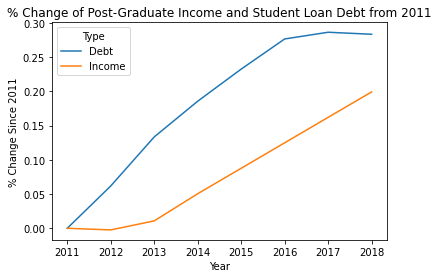

In [14]:
# Compute nationwide average debt for each year
mean_yearly_debt = mean_debt.groupby(["year"], as_index=False).mean()

# Normalize yearly debt to be percentage change from 2011
debt_2011 = mean_yearly_debt[mean_yearly_debt["year"] == "2011"]["debt"]
mean_yearly_debt["debt"] = mean_yearly_debt.apply(lambda row: row["debt"] / debt_2011 - 1, axis=1)
mean_yearly_debt.columns = ["Year", "Debt"]

# Compute nationwide average income for each year
mean_yearly_income = mean_income.groupby(["year"], as_index=False).mean()

# Normalize yearly income to be percentage change from 2011
income_2011 = mean_yearly_income[mean_yearly_income["year"] == "2011"]["income"]
mean_yearly_income["income"] = mean_yearly_income.apply(lambda row: row["income"] / income_2011 - 1, axis=1)
mean_yearly_income.columns = ["Year", "Income"]

# Merged dataframe
debt_and_income_data = pd.merge(mean_yearly_debt, mean_yearly_income, on="Year", how="left")
debt_and_income_data = pd.melt(debt_and_income_data, id_vars = ["Year"], value_vars = ["Debt", "Income"], var_name = "Type")

# Plot both percent growths on same plot
compare_plot = sns.lineplot(data=debt_and_income_data, x="Year", y="value", hue="Type")
compare_plot.set(xlabel='Year', ylabel="% Change Since 2011", title="% Change of Post-Graduate Income and Student Loan Debt from 2011");

From this plot, we can see a more clear comparison between student loan debt and post-graduate income. While both have seen substantial increases over the past 10 years, **student loan debt has increased by nearly 30% since 2011 while post-graduate income has only increased by 20%**. This finding indicates that college is getting more expensive with time, and while college graduates are earning more year-by-year, the relationship between these factors is not one-to-one as college debt is increasing at a more rapid rate.

# Completion Rate vs Income vs Cost of College

Since student loan debt has increased by a substantial amount, it's important to know if going to a higher costing college (and possibly taking out a bigger loan) correlates to anything. It's also important to know how likely it is someone is to graduate from that program, to ensure they get the most out of their money.

First we gather these three statistics from the year 2018.

In [15]:
# Set the year range we are interested in
START_YEAR = 2011
END_YEAR = 2021

# Generate a list of all years in the given range (years are converted to strings)
years = range(START_YEAR, END_YEAR + 1)
years = [str(year) for year in years]
years = ["2018"]

full_cmp = pd.DataFrame()

for year in years:
    # Retrieve all debt data for the specified year from scorecard
    year_cmp = get_all_data_for_year(year = year, dev_category = "completion", var_name = "completion_rate_4yr_100nt")
    
    # Format the resulting data frame
    year_cmp = year_cmp.rename(columns = { "{0}.completion.completion_rate_4yr_100nt".format(year): "completion", "school.name": "name", "school.state": "state", "school.ownership": "ownership" })
    year_cmp["year"] = year
    
    # Append current year's debt data to larger data frame
    full_cmp = pd.concat([full_cmp, year_cmp], axis=0)

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
full_cmp = full_cmp[~full_cmp["state"].isin(US_TERRITORIES)]
    
# Set the college id as row indicies
full_cmp = full_cmp.set_index("id") 

In [16]:
# Set the year range we are interested in
START_YEAR = 2011
END_YEAR = 2021

# Generate a list of all years in the given range (years are converted to strings)
years = range(START_YEAR, END_YEAR + 1)
years = ["2018"]

full_cost = pd.DataFrame()

for year in years:
    # Retrieve all debt data for the specified year from scorecard
    year_cost = get_all_data_for_year(year = year, dev_category = "cost", var_name = "attendance.academic_year")
    
    # Format the resulting data frame
    year_cost = year_cost.rename(columns = { "{0}.cost.attendance.academic_year".format(year): "cost", "school.name": "name", "school.state": "state", "school.ownership": "ownership" })
    year_cost["year"] = year
    
    # Append current year's debt data to larger data frame
    full_cost = pd.concat([full_cost, year_cost], axis=0)

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
full_cost = full_cost[~full_cost["state"].isin(US_TERRITORIES)]
    
# Set the college id as row indicies
full_cost = full_cost.set_index("id") 

In [17]:
# Set the year range we are interested in
START_YEAR = 2011
END_YEAR = 2021

# Generate a list of all years in the given range (years are converted to strings)
years = range(START_YEAR, END_YEAR + 1)
years = ["2018"]

full_income = pd.DataFrame()

for year in years:
    # Retrieve all debt data for the specified year from scorecard
    year_income = get_all_data_for_year(year = year, dev_category = "earnings", var_name = "10_yrs_after_entry.median")
    
    # Format the resulting data frame
    year_income = year_income.rename(columns = { "{0}.earnings.10_yrs_after_entry.median".format(year): "income", "school.name": "name", "school.state": "state", "school.ownership": "ownership" })
    year_income["year"] = year
    
    # Append current year's debt data to larger data frame
    full_income = pd.concat([full_income, year_income], axis=0)

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
full_income = full_income[~full_income["state"].isin(US_TERRITORIES)]
    
# Set the college id as row indicies
full_income = full_income.set_index("id") 

In [18]:
full_cmp = full_cmp.dropna()
full_cost = full_cost.dropna()
full_income = full_income.dropna()
full = pd.concat([full_cmp, full_cost,full_income], axis=1)
full = full.dropna()
full = full.loc[:,~full.columns.duplicated()].copy()
full['completion'] = full['completion'] * 100

Now we can plot each of these against each other and run a t test for significance.

1.0066739192464156


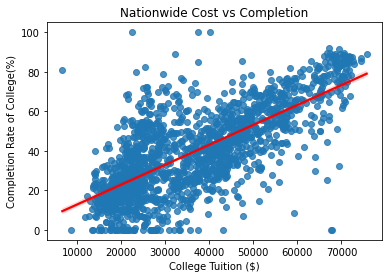

In [19]:
lin_plot = sns.regplot(data = full, x = "cost", y = "completion",line_kws={"color": "red"})
lin_plot.set(xlabel='College Tuition ($)', ylabel="Completion Rate of College(%)", title="Nationwide Cost vs Completion");
slope, intercept, r, p, sterr = stats.linregress(x=lin_plot.get_lines()[0].get_xdata(),
                                                       y=lin_plot.get_lines()[0].get_ydata())
print(slope*1000)
#for every 1000 dollar increase in tuition, the completion percentage goes up by roughly 1%!

In [20]:
stats.ttest_ind(full['cost'],
                full['completion'])
#p value less close to 0 definite correlation

Ttest_indResult(statistic=93.60582098729353, pvalue=0.0)

We can see that cost of tuition and completion rate are significantly positively correlated, meaning **a percent increase in tuition increases the completion percentage by about a percent!**

419.1477008702807


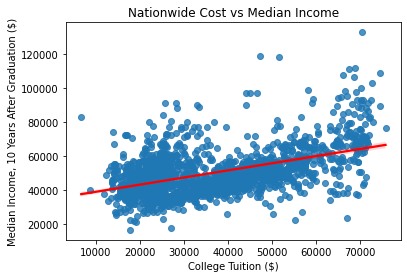

In [21]:
lin_plot2 = sns.regplot(data = full, x = "cost", y = "income",line_kws={"color": "red"})
lin_plot2.set(xlabel='College Tuition ($)', ylabel="Median Income, 10 Years After Graduation ($)", title="Nationwide Cost vs Median Income");
slope, intercept, r, p, sterr = stats.linregress(x=lin_plot2.get_lines()[0].get_xdata(),
                                                       y=lin_plot2.get_lines()[0].get_ydata())
print(slope*1000)
#for every 1000 dollar increase in tuition, the income goes up by 420 dollars.

In [22]:
stats.ttest_ind(full['cost'],
                full['income'])
#p value close to 0, definite correlation

Ttest_indResult(statistic=-26.427955134968617, pvalue=1.984183312664456e-139)

Next, we see that cost and income are significantly positively correlated, meaning **a thousand dollar increase in tuition increases the expected income by about 420 dollars!**

349.60185770060394


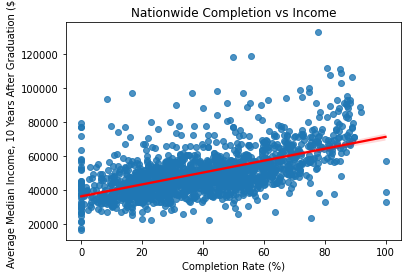

In [23]:
lin_plot5 = sns.regplot(data = full, x = "completion", y = "income",line_kws={"color": "red"})
lin_plot5.set(xlabel='Completion Rate (%)', ylabel="Average Median Income, 10 Years After Graduation ($)", title="Nationwide Completion vs Income");
slope, intercept, r, p, sterr = stats.linregress(x=lin_plot5.get_lines()[0].get_xdata(),
                                                       y=lin_plot5.get_lines()[0].get_ydata())
print(slope)
#every time the completion rate goes up 1%, you're expected to make 350 dollars more.

In [24]:
stats.ttest_ind(full['income'],
                full['completion'])
#p value less close to 0 definite correlation. higher completion = higher income

Ttest_indResult(statistic=149.56450282456518, pvalue=0.0)

Finally, we see that completion rate and income are significantly positively correlated, meaning **a percent increase in completion rate increases the expected income by 350 dollars!**

In [25]:
full_income.sort_values('income', ascending=False).head(10)
#snapshot of the top 10 earning universities, engineering, health, technology based schools as expected would earn the most.

,income,name,state,ownership,year
id,,,,,
441982,132969.0,Franklin W Olin College of Engineering,MA,2,2018
122296,123966.0,Samuel Merritt University,CA,2,2018
179265,121576.0,University of Health Sciences and Pharmacy in ...,MO,2,2018
188526,119112.0,Albany College of Pharmacy and Health Sciences,NY,2,2018
166656,118171.0,MCPHS University,MA,2,2018
196255,114551.0,SUNY Downstate Health Sciences University,NY,1,2018
110404,112166.0,California Institute of Technology,CA,2,2018
166683,111222.0,Massachusetts Institute of Technology,MA,2,2018
115409,108988.0,Harvey Mudd College,CA,2,2018


If we take a quick look at the snapshot of top earning universities, we can see that most of these are STEM specialized schools.

In [26]:
full_income.sort_values('income', ascending=True).head(10)
#snapshot of the top 10 earning universities, engineering, health, technology based schools as expected would earn the most.

,income,name,state,ownership,year
id,,,,,
197601,16792.0,Yeshiva Karlin Stolin,NY,2,2018
455257,17714.0,Yeshiva of Machzikai Hadas,NY,2,2018
197018,21284.0,United Talmudical Seminary,NY,2,2018
197735,21878.0,Yeshivath Viznitz,NY,2,2018
157030,22385.0,Kentucky Mountain Bible College,KY,2,2018
384254,22833.0,Beacon College,FL,2,2018
219505,23135.0,American Baptist College,TN,2,2018
192712,24000.0,Manhattan School of Music,NY,2,2018
444088,24653.0,Brookline College-Albuquerque,NM,3,2018


We can also see that the bottom few earning schools are religious or humanities schools. Let's run to see if this trend is true.

In [27]:
full_cmp.sort_values('completion', ascending=False).head(10)
#top ten most completion rate for the year 2018.

,completion,name,state,ownership,year
id,,,,,
233356,1.0000,Bon Secours Memorial College of Nursing,VA,2,2018
449348,1.0000,Huntsville Bible College,AL,2,2018
260813,1.0000,Platt College-Aurora,CO,3,2018
132842,1.0000,Albizu University-Miami,FL,2,2018
447421,1.0000,Eagle Gate College-Layton,UT,3,2018
234207,0.9186,Washington and Lee University,VA,2,2018
152080,0.9148,University of Notre Dame,IN,2,2018
164155,0.9012,United States Naval Academy,MD,1,2018
168342,0.8958,Williams College,MA,2,2018


In [28]:
# Set the year range we are interested in
START_YEAR = 2011
END_YEAR = 2018

# Generate a list of all years in the given range (years are converted to strings)
years = range(START_YEAR, END_YEAR + 1)
years = [str(year) for year in years]

# MANUAL OVERWRITE: ONLY 2007, 2009, 2011, 2012, 2013, 2014, 2018 available
years = ["2018"]

full_hum_data = pd.DataFrame()

for year in years:
    # Retrieve all income data for the specified year from scorecard
    year_hum_data = get_all_data_for_year(year = year, dev_category = "academics", var_name = "program_percentage.humanities")
    
    # Format the resulting data frame
    year_hum_data = year_hum_data.rename(columns = { "{0}.academics.program_percentage.humanities".format(year): "hum", "school.name": "name", "school.state": "state", "school.ownership": "ownership" })
    year_hum_data["year"] = year
    
    # Remove any NA entries
    year_hum_data = year_hum_data.dropna(subset=["hum"])
    
    # Append current year's income data to larger data frame
    full_hum_data = pd.concat([full_hum_data, year_hum_data], axis=0)

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
full_hum_data = full_hum_data[~full_hum_data["state"].isin(US_TERRITORIES)]

# Set the college id as row indicies
full_hum_data = full_hum_data.set_index("id") 

In [29]:
full = pd.concat([full_hum_data, full], axis=1)
full = full.dropna()
full = full.loc[:,~full.columns.duplicated()].copy()

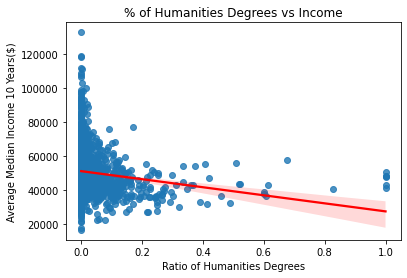

In [30]:
lin_plot3 = sns.regplot(data = full, x = "hum", y = "income",line_kws={"color": "red"})
lin_plot3.set(xlabel='Ratio of Humanities Degrees', ylabel="Average Median Income 10 Years($)", title="% of Humanities Degrees vs Income");
slope, intercept, r, p, sterr = stats.linregress(x=lin_plot3.get_lines()[0].get_xdata(),
                                                       y=lin_plot3.get_lines()[0].get_ydata())

In [31]:
stats.ttest_ind(full['hum'],
                full['income'])
#p value close to 0, definite correlation

Ttest_indResult(statistic=-149.68272729410415, pvalue=0.0)

In [32]:
# Set the year range we are interested in
START_YEAR = 2011
END_YEAR = 2018

# Generate a list of all years in the given range (years are converted to strings)
years = range(START_YEAR, END_YEAR + 1)
years = [str(year) for year in years]

# MANUAL OVERWRITE: ONLY 2007, 2009, 2011, 2012, 2013, 2014, 2018 available
years = ["2018"]

full_eng_data = pd.DataFrame()

for year in years:
    # Retrieve all income data for the specified year from scorecard
    year_eng_data = get_all_data_for_year(year = year, dev_category = "academics", var_name = "program_percentage.engineering")
    
    # Format the resulting data frame
    year_eng_data = year_eng_data.rename(columns = { "{0}.academics.program_percentage.engineering".format(year): "eng", "school.name": "name", "school.state": "state", "school.ownership": "ownership" })
    year_eng_data["year"] = year
    
    # Remove any NA entries
    year_eng_data = year_eng_data.dropna(subset=["eng"])
    
    # Append current year's income data to larger data frame
    full_eng_data = pd.concat([full_eng_data, year_eng_data], axis=0)

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
full_eng_data = full_eng_data[~full_eng_data["state"].isin(US_TERRITORIES)]

# Set the college id as row indicies
full_eng_data = full_eng_data.set_index("id") 

In [33]:
full = pd.concat([full_eng_data, full], axis=1)
full = full.dropna()
full = full.loc[:,~full.columns.duplicated()].copy()

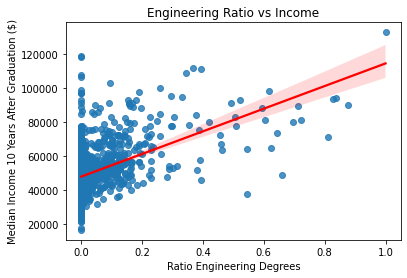

In [34]:
lin_plot4 = sns.regplot(data = full, x = "eng", y = "income",line_kws={"color": "red"})
lin_plot4.set(xlabel='Ratio Engineering Degrees', ylabel="Median Income 10 Years After Graduation ($)", title="Engineering Ratio vs Income");
slope, intercept, r, p, sterr = stats.linregress(x=lin_plot3.get_lines()[0].get_xdata(),
                                                       y=lin_plot3.get_lines()[0].get_ydata())

In [35]:
stats.ttest_ind(full['eng'],
                full['income'])
#p value close to 0, definite correlation

Ttest_indResult(statistic=-149.68273679401705, pvalue=0.0)

In [36]:
full['ioverc'] = full['income']/full['cost']
full.sort_values('ioverc', ascending=False).head(10)
#snapshot of the top 10 income per cost universities, engineering, health, technology based schools as expected would earn the most.

full['ioverc'] = full['income']/full['cost']
full.sort_values('ioverc', ascending=True).head(10)
#snapshot of the bottom 10 income per cost universities, engineering, health, technology based schools as expected would earn the most.

,eng,name,state,ownership,year,hum,completion,cost,income,ioverc
id,,,,,,,,,,
192712,0.0,Manhattan School of Music,NY,2,2018,0.0000,75.58,67051.0,24000.0,0.357936
384254,0.0,Beacon College,FL,2,2018,0.0517,41.94,55241.0,22833.0,0.413334
214971,0.0,Pennsylvania Academy of the Fine Arts,PA,2,2018,0.0000,63.64,56848.0,27570.0,0.484977
127653,0.0,Naropa University,CO,2,2018,0.0000,33.33,50081.0,26157.0,0.522294
122454,0.0,San Francisco Art Institute,CA,2,2018,0.0000,32.10,69525.0,37487.0,0.539187
164748,0.0,Berklee College of Music,MA,2,2018,0.0000,50.22,63027.0,34452.0,0.546623
111081,0.0,California Institute of the Arts,CA,2,2018,0.0000,50.84,69015.0,37733.0,0.546736
202073,0.0,Cleveland Institute of Music,OH,2,2018,0.0000,68.33,66966.0,38737.0,0.578458
122506,0.0,San Francisco Conservatory of Music,CA,2,2018,0.0000,50.00,65045.0,37744.0,0.580275


We do indeed see a positive correlation between higher percentage of engineering students at the college and income, and a negative correlation between higher percentage of humanities students at the college and income.

So what have we learned? The more you pay for college, the more your income is higher, and the more you're likely to graduate. Often times, the more expensive colleges are private institutions. So let's take a look at the distinction between private and public colleges.

# Income and Debt in Public vs Private Institutions

## Public vs Private Institutions Median Income Analysis

There are many factors that play into why a student chooses to attend a college. If cost were to be their main consideration, many students would tend to attend in-state public universities due to streotypically lower costs and convenience. Consequently, we are also interested in investigating if there is a difference in the quality of education in __public vs. private institutions__ based on the __median earnings of graduates 10 years after graduation__.

In [37]:
# Get data of the latest year (2018)
ownership = get_scorecard_data(year = "latest", dev_category = "earnings", var_name = "10_yrs_after_entry.median")

result = ownership.json()
pages = result["metadata"]["page"]
results = result["results"]
max_page_num = result["metadata"]["total"]//100 + 1

# Loop over remaining pages
for p in range(pages, max_page_num + 1):
    results += get_scorecard_data(year = "latest", dev_category = "earnings", var_name = "10_yrs_after_entry.median", page = p).json()["results"]
    time.sleep(0.1) # Slow down request from API

In [38]:
# Create dataframe
ownership_df = pd.DataFrame(results)
ownership_df = ownership_df.set_index('id') # Set index by "ID"

# Replace column name
ownership_df = ownership_df.rename(columns={'latest.earnings.10_yrs_after_entry.median': 'median_earnings', 'school.name': 'name', 'school.state': 'state', 'school.ownership': 'ownership'})

# Drop NAs value
ownership_df = ownership_df.dropna(subset=['median_earnings'])


We decided to merge the `private for-profit` and `private non-profit` colleges into one category as they both do not receive funding from the government and falls under the same umbrella.

In [39]:
# Replace school.ownership = 1 to Public 
# school.ownership = 2 or 3 to Private 
ownership_df['ownership'] = ownership_df['ownership'].replace([1], 'Public')
ownership_df['ownership'] = ownership_df['ownership'].replace([2,3], 'Private')

# Remove duplicated entries I found while performing data exploration 
ownership_df = ownership_df.drop_duplicates()

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
ownership_df = ownership_df[~ownership_df["state"].isin(US_TERRITORIES)]

In [40]:
# Number of public vs. private universities
count_ownership = ownership_df.groupby("ownership", as_index=False)["name"].count()
count_ownership = count_ownership.rename(columns={'ownership': 'ownership', 'name': 'count'})

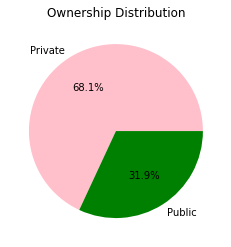

In [41]:
# Plot pie chart of percentage of public vs. private universities
plt.pie(count_ownership['count'], labels=count_ownership['ownership'], autopct='%1.1f%%', colors = ['pink', 'green'])
plt.title('Ownership Distribution')
plt.show()

From the pie chart, we can see that there is a higher percentage of private institutions compared to public institutions in the United States.

In [42]:
# Mean earnings by state
state_earnings = ownership_df.groupby('state', as_index=False)['median_earnings'].mean()
state_earnings = state_earnings.rename(columns={'median_earnings': 'average_median_earnings'})

# Plot interactive map
fig = go.Figure(data=go.Choropleth(locations = state_earnings['state'],z = state_earnings['average_median_earnings'].astype(float),
                                colorscale = 'Greens', locationmode = 'USA-states', colorbar_title = "USD"))

fig.update_layout(title_text = 'Average Median Earnings by State 10 years after Graduation', title_font_size=20, geo_scope='usa')
fig.show()

From the interactive map, the states that stood out the most with the highest average median earnings are California and Massachusetts (darker green) and with the lowest average median earnings are the states New Mexico and Mississippi.

In [43]:
# Subset by public vs. private
public = ownership_df[ownership_df["ownership"] == "Public"]
private = ownership_df[ownership_df["ownership"] == "Private"]

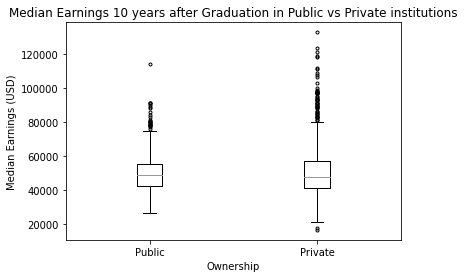

In [44]:
# create box plot
plt.boxplot([public['median_earnings'], 
            private['median_earnings']], 
            labels=['Public', 'Private'], flierprops=dict(marker='o', markersize=3))
plt.xlabel('Ownership')
plt.ylabel('Median Earnings (USD)')
plt.title('Median Earnings 10 years after Graduation in Public vs Private institutions')
plt.show()

In [45]:
print(public['median_earnings'].mean())
print(private['median_earnings'].mean())

50663.650994575044
51259.32909245123


From the box plot, we can see that students that graduated from public schools have average median earnings of `$50663.65` which is only __slightly lower__ than the earnings of students graduated from private schools, `$51259.33`. Private colleges have a larger interquartile range with more outliers skewed towards a higher median earning compared to public colleges. We will use the independent T-test, a parametric test, to test for a statistically significant difference in the means between public and private institutions.

In [46]:
stats.ttest_ind(public['median_earnings'],
                public['median_earnings'])

Ttest_indResult(statistic=0.0, pvalue=1.0)

The independent T-test shows that there is __no statistically significant difference__ in the average median earnings between public and private institutions as the p-value > 0.05.

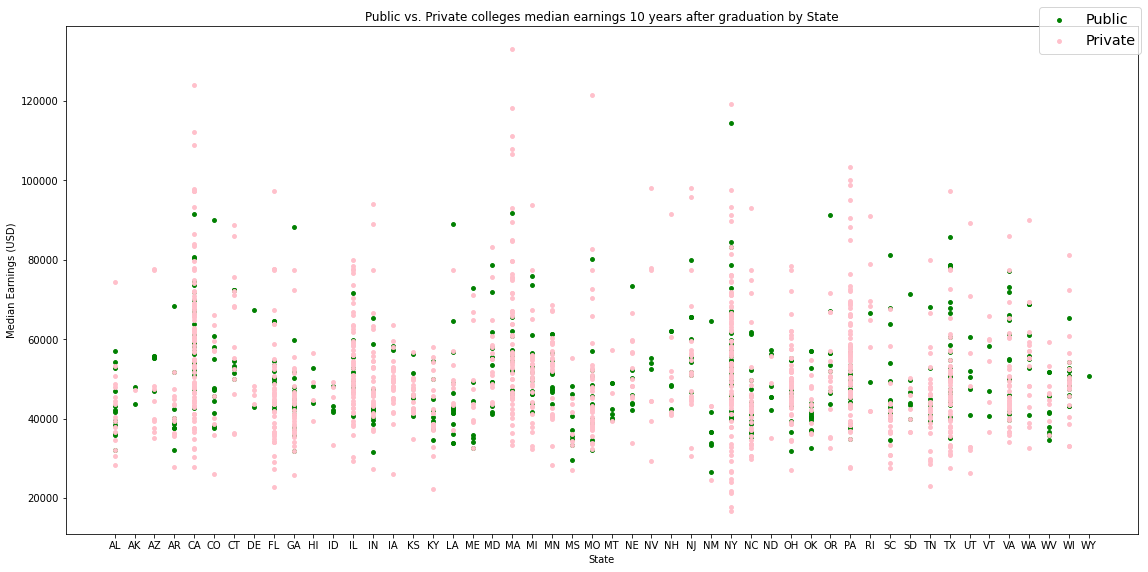

In [47]:
# Create scatter plot to show the relationship between earnings and state for each ownership category
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size to 10x6
ax.scatter(public['state'], public['median_earnings'], label='Public', color = "green", s = 15)
ax.scatter(private['state'], private['median_earnings'], label='Private', color = "pink", s = 15)
ax.set_xlabel('State')
ax.set_ylabel('Median Earnings (USD)')
plt.title('Public vs. Private colleges median earnings 10 years after graduation by State')
fig.legend(fontsize ='x-large', loc = 1) # legend

fig.tight_layout()
plt.show()

The scatter plot shows the median earnings of each college by state and ownership. We can see that California, Massachusetts, and New York states have the largest ranges of earnings. There seem to be __no pattern__ between public and private institutions as we see both colors at the maximum/minimum median earnings in each state, which supports our independent T-test results. 

In [48]:
# Mean of public vs. private per state
mean_public = public.groupby('state', as_index=False)['median_earnings'].mean()
mean_public = mean_public.rename(columns={'median_earnings': 'public_average_median_earnings'})

mean_private = private.groupby('state', as_index=False)['median_earnings'].mean()
mean_private = mean_private.rename(columns={'median_earnings': 'private_average_median_earnings'})

# Merge both dataframes together
mean_earnings = mean_public.merge(mean_private, how='inner', on='state')

# Merge averegae mean earnings of all ownership by state to `mean_earnings`
mean_earnings = mean_earnings.merge(state_earnings, on='state')

# sort merged dataframe by mean values
mean_earnings = mean_earnings.sort_values(by='average_median_earnings', ascending = False)
mean_earnings.set_index('state', inplace=True)  # Set index by "state"

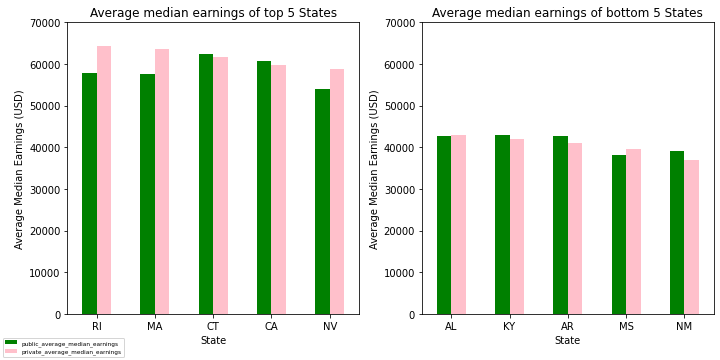

In [49]:
# Subset top 5 / bottom 5 states of average median earnings to be plotted on a grouped bar graph
top5_state = mean_earnings.head(5)
bottom5_state = mean_earnings.tail(5)

# Select columns for plotting
cols = ['public_average_median_earnings', 'private_average_median_earnings']

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Top 5 states
top5_state[cols].plot(kind='bar', ax=axs[0], rot=0, legend=False, color = ['green', 'pink'])
axs[0].set_xlabel('State')
axs[0].set_ylabel('Average Median Earnings (USD)')
axs[0].set_title('Average median earnings of top 5 States')
axs[0].set_ylim([0, 70000])
fig.legend(loc=3, fontsize ='xx-small') # legend

# Bottom 5 states
bottom5_state[cols].plot(kind='bar', ax=axs[1], rot=0, legend=False, color = ['green', 'pink'])
axs[1].set_xlabel('State')
axs[1].set_ylabel('Average Median Earnings (USD)')
axs[1].set_title('Average median earnings of bottom 5 States')
axs[1].set_ylim([0, 70000])

fig.tight_layout()
plt.show()

We can see from the average median earnings from the top 5 and bottom 5 states that there is no clear trend in the difference in income from private and public institutions.

Overall, from the visualizations and statistics calculated, we can conclude that there are __no significance difference__ in median earnings 10 years after graduation between public and private institutions in 2018.

## Public vs Private Student Loan Debt Analysis
Another big question many students have is regrading the cost difference and how much load a student takes out in public vs. private institutions. Stereotypically, students tend to take out more loans for private schools due to a higher tuition fee. We want to analyze if there is a significant difference in __student loan debt in public vs. private institutions__.

In [ ]:
# Get data of the latest year (2018)
loan = get_scorecard_data(year = "latest", dev_category = "aid", var_name = "loan_principal")

result = loan.json()
pages = result["metadata"]["page"]
results = result["results"]
max_page_num = result["metadata"]["total"]//100 + 1

# Loop over remaining pages
for p in range(pages, max_page_num + 1):
    results += get_scorecard_data(year = "latest", dev_category = "aid", var_name = "loan_principal", page = p).json()["results"]
    time.sleep(0.1) # 1 seconds # Slow down request from API

In [ ]:
# Create dataframe
loan_df = pd.DataFrame(results)
loan_df = loan_df.set_index('id') # Set index by "ID"

# Replace column name
loan_df = loan_df.rename(columns={'latest.aid.loan_principal': 'loan_principal', 'school.name': 'name', 'school.state': 'state', 'school.ownership': 'ownership'})

# Drop NAs value
loan_df = loan_df.dropna(subset=['loan_principal'])

# Remove data points for U.S. territories
US_TERRITORIES = ["GU", "DC", "PR", "VI"]
loan_df = loan_df[~loan_df["state"].isin(US_TERRITORIES)]

# Replace school.ownership = 1 to Public 
# school.ownership = 2 or 3 to Private 
loan_df['ownership'] = loan_df['ownership'].replace([1], 'Public')
loan_df['ownership'] = loan_df['ownership'].replace([2,3], 'Private')

# Remove duplicated entries
loan_df = loan_df.drop_duplicates()

In [ ]:
# Mean Student Loan Debt by state
state_loan = loan_df.groupby('state', as_index=False)['loan_principal'].mean()
state_loan = state_loan.rename(columns={'loan_principal': 'average_loan_principal'})

# Plot interactive map
fig = go.Figure(data=go.Choropleth(locations = state_loan['state'],z = state_loan['average_loan_principal'].astype(float),
                                colorscale = 'Reds', locationmode = 'USA-states', colorbar_title = "USD"))

fig.update_layout(title_text = 'Average Student Loan Debt by State', title_font_size=20, geo_scope='usa')
fig.show()

The state with the higher student loan debt can be clearly seen from this cloropleth map to be Pennsylvania. Most states have a student loan debt between \\$15k and \\$18k. We will perform further analysis of the distribution by creating a box plot and perfoming an independent t-test, similar to the median income variable analysis we analyzed above.

In [ ]:
# Subset by public vs. private
public_loan = loan_df[loan_df["ownership"] == "Public"]
private_loan = loan_df[loan_df["ownership"] == "Private"]

In [ ]:
# Create box plot
plt.boxplot([public_loan['loan_principal'], 
            private_loan['loan_principal']], 
            labels=['Public', 'Private'], flierprops=dict(marker='o', markersize=3))
plt.xlabel('Ownership')
plt.ylabel('Student Loan Debt (USD)')
plt.title('Student Loan Debt in Public vs Private institutions')
plt.show()

In [ ]:
print(public_loan['loan_principal'].mean())
print(private_loan['loan_principal'].mean())

From the box plot, we can see that students that graduated from public schools have average student loan debt of `$14745.43` which is lower than the student loan debt of students graduated from private schools, `$17041.89`. Private colleges have a larger interquartile range with more outliers skewed towards a higher median earning compared to public colleges. We will use the independent T-test, a parametric test, to test for a statistically significant difference in the means between public and private institutions.

In [ ]:
stats.ttest_ind(public_loan['loan_principal'],
                private_loan['loan_principal'])

The independent T-test shows that there is a __statistically significant difference__ in the average student loan debt between public and private institutions as the p-value < 0.05.

In [ ]:
# Create scatter plot to show the relationship between earnings and state for each ownership category
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size to 10x6
ax.scatter(public_loan['state'], public_loan['loan_principal'], label='Public', color = "green", s = 15)
ax.scatter(private_loan['state'], private_loan['loan_principal'], label='Private', color = "pink", s = 15)
ax.set_xlabel('State')
ax.set_ylabel('Student Loan Debt (USD)')
plt.title('Public vs. Private Institutions Student Loan Debt by State')
fig.legend(fontsize ='x-large', loc = 1) # legend

fig.tight_layout()
plt.show()

From the scatter plot, we can see that there is a pretty clear pattern where when there is a high student loan debt, most of the institutions are private for every state. However, with lower student loan debt, there exist both public and private institutions.

In [ ]:
# Mean of public vs. private per state
mean_public_loan = public_loan.groupby('state', as_index=False)['loan_principal'].mean()
mean_public_loan = mean_public_loan.rename(columns={'loan_principal': 'public_loan_principal'})

mean_private_loan = private_loan.groupby('state', as_index=False)['loan_principal'].mean()
mean_private_loan = mean_private_loan.rename(columns={'loan_principal': 'private_loan_principal'})

# Merge both dataframes together
mean_loan = mean_public_loan.merge(mean_private_loan, how='inner', on='state')

# Merge averegae mean earnings of all ownership by state to `mean_earnings`
mean_loan = mean_loan.merge(state_loan, on='state')

# sort merged dataframe by mean values
mean_loan = mean_loan.sort_values(by='average_loan_principal', ascending = False)
mean_loan.set_index('state', inplace=True)  # Set index by "state"

In [ ]:
# Subset top 5 / bottom 5 states of average median earnings to be plotted on a grouped bar graph
top5_state_loan = mean_loan.head(5)
bottom5_state_loan = mean_loan.tail(5)

# Select columns for plotting
cols = ['public_loan_principal', 'private_loan_principal']

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Top 5 states
top5_state_loan[cols].plot(kind='bar', ax=axs[0], rot=0, legend=False, color = ['green', 'pink'])
axs[0].set_xlabel('State')
axs[0].set_ylabel('Student Loan Debt (USD)')
axs[0].set_title('Student Loan Debt of Top 5 States')
axs[0].set_ylim([0, 25000])
fig.legend(loc=3, fontsize ='xx-small') # legend

# Bottom 5 states
bottom5_state_loan[cols].plot(kind='bar', ax=axs[1], rot=0, legend=False, color = ['green', 'pink'])
axs[1].set_xlabel('State')
axs[1].set_ylabel('Student Loan Debt (USD)')
axs[1].set_title('Student Loan Debt of Bottom 5 States')
axs[1].set_ylim([0, 25000])

fig.tight_layout()
plt.show()

From the grouped bar graphs above, we can see that in 8/10 of the states, student loan debt is higher in private institutions compared to public institutions.

Overall, from the visualizations and statistics calculated, we can conclude that there is a __significance difference__ in average student loan debt between public and private institutions in 2018.

# Conclusion

In conclusion, despite the significant increase in student debt and post-graduation income over the years analyzed, it is still worth attending college. Our analysis found a positive correlation between post-graduation income, completion rate, and the cost of college. It is possible to find lower-costing, high-income colleges, especially in nursing and engineering-based STEM programs. Attending these colleges gives the highest income with the lowest debt.

Furthermore, we found that while median income does not differ much between public and private institutions, student debt is significantly higher in private institutions. However, it is possible to graduate from a private institution with low student debt.

Therefore, finding a balance between the amount of debt you incur and the amount you will make largely depends on the type of college you attend and the degree you choose to graduate with. It is important to research before attending college to ensure that you make an informed decision about your future financial stability. Overall, college is still worth it, and with careful planning and consideration, students can find success both academically and financially after graduation.



# References

1. Choropleth Documentation: https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e

2. College Scorecard Data Documentation: https://collegescorecard.ed.gov/data/documentation/

3. Seaborn Documentation: https://seaborn.pydata.org/